<a href="https://www.kaggle.com/code/kuntalpal/pycaret-automl-regression?scriptVersionId=121936325" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wids-2023/train_data.csv
/kaggle/input/wids-2023/test_data.csv
/kaggle/input/wids-2023/sample_solution.csv


In [3]:
import numpy as np
import pandas as pd
import IPython
import IPython.display
import tensorflow as tf
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.utils import shuffle

In [4]:
train_df = pd.read_csv('/kaggle/input/wids-2023/train_data.csv')
test_df = pd.read_csv("/kaggle/input/wids-2023/test_data.csv")
sample = pd.read_csv('/kaggle/input/wids-2023/sample_solution.csv')

print(f"train_shape:{train_df.shape},test_shape:{test_df.shape},Sample_shape:{sample.shape}")

train_shape:(375734, 246),test_shape:(31354, 245),Sample_shape:(31354, 2)


In [5]:
# Explore how the datatypes look like for all the columns
count=0
for feature in list(train_df.columns):
    
    if train_df[feature].dtype == 'float64':
        count +=1
    else:
        print(feature,train_df[feature].dtype)
print(count)
        

index int64
startdate object
climateregions__climateregion object
mjo1d__phase int64
mei__meirank int64
mei__nip int64
240


In [6]:
# Check out for missing values in training data
all_features_nan =  train_df.columns[train_df.isna().any()].tolist()


for feature in all_features_nan:
    print(feature,train_df[feature].isna().sum())

nmme0-tmp2m-34w__ccsm30 15934
nmme-tmp2m-56w__ccsm3 10280
nmme-prate-34w__ccsm3 8738
nmme0-prate-56w__ccsm30 15934
nmme0-prate-34w__ccsm30 15934
nmme-prate-56w__ccsm3 10280
nmme-tmp2m-34w__ccsm3 8738
ccsm30 15934


In [7]:
# Range of dates in training and test dataset
train_df['startdate'] = pd.to_datetime(train_df['startdate'])
test_df['startdate'] = pd.to_datetime(test_df['startdate'])
print(train_df['startdate'].min(),train_df['startdate'].max())
print(test_df['startdate'].min(),test_df['startdate'].max())

2014-09-01 00:00:00 2016-08-31 00:00:00
2022-11-01 00:00:00 2022-12-31 00:00:00


In [8]:
# Group places together by latitude and longtitude
train_df.groupby(['lat','lon']).size()

lat       lon     
0.000000  0.833333    731
          0.866667    731
0.045455  0.833333    731
          0.866667    731
          0.900000    731
                     ... 
1.000000  0.733333    731
          0.766667    731
          0.800000    731
          0.833333    731
          0.866667    731
Length: 514, dtype: int64

In [9]:
test_df.groupby(['lat','lon']).ngroup()

0          0
1          0
2          0
3          0
4          0
        ... 
31349    513
31350    513
31351    513
31352    513
31353    513
Length: 31354, dtype: int64

In [10]:
# Imputing Missing values
imputer = SimpleImputer(strategy='mean')
for feature in all_features_nan:
    train_df[feature] = imputer.fit_transform(train_df[[feature]]).ravel()

In [11]:
# Round off the latitude and longitude till the 14th place
train_df.loc[:,'lat']=round(train_df.lat,14)
train_df.loc[:,'lon']=round(train_df.lon,14)
test_df.loc[:,'lat']=round(test_df.lat,14)
test_df.loc[:,'lon']=round(test_df.lon,14)

In [12]:
# transform non-numerical labels  to numerical labels.
le = preprocessing.LabelEncoder()
train_df['climateregions__climateregion'] = le.fit_transform(train_df['climateregions__climateregion'])
test_df['climateregions__climateregion'] = le.transform(test_df['climateregions__climateregion'])
train_df['climateregions__climateregion']

0         0
1         0
2         0
3         0
4         0
         ..
375729    9
375730    9
375731    9
375732    9
375733    9
Name: climateregions__climateregion, Length: 375734, dtype: int64

In [13]:
# Replace latitude and lontitude info with 514 unique locations
train_df['unique_loc'] = train_df.groupby(['lat','lon']).ngroup()
test_df['unique_loc'] = test_df.groupby(['lat','lon']).ngroup()

In [14]:
# Replace start date with year, month and day
train_df['year'] = train_df['startdate'].dt.year
train_df['month'] = train_df['startdate'].dt.month
train_df['day_of_year'] = train_df['startdate'].dt.dayofyear

test_df['year'] = test_df['startdate'].dt.year
test_df['month'] = test_df['startdate'].dt.month
test_df['day_of_year'] = test_df['startdate'].dt.dayofyear

In [15]:
# Drop uncessary columns including the target column
drop_cols = ['index', 'startdate','lat', 'lon']

target = train_df['contest-tmp2m-14d__tmp2m']
train_df = train_df.drop(columns=drop_cols)
train_df = train_df.drop(columns=['contest-tmp2m-14d__tmp2m'])
test_df = test_df.drop(columns=drop_cols)

In [16]:
corr_test = test_df.corr().abs()

In [17]:
upper_tri_test = corr_test.where(np.triu(np.ones(corr_test.shape),k=1).astype(np.bool))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


In [18]:
to_drop_test = [column for column in upper_tri_test.columns if any(upper_tri_test[column] > 0.9)]

In [19]:
train_df = train_df.drop(columns=to_drop_test)
test_df = test_df.drop(columns=to_drop_test)

In [20]:
%%capture
!pip install --pre pycaret

In [21]:
from pycaret.regression import *
s = setup(train_df, target = target,
         session_id = 123,
         normalize = True,
         normalize_method = 'minmax',
         use_gpu = False,
         #log_experiment = 'wandb',
         #experiment_name = 'climate_train',
         #profile = True,
         train_size = 0.8,
         fold_strategy = 'timeseries',
         #numeric_features = ['climateregions__climateregion','month','unique_loc']
         remove_multicollinearity = False,
         pca = False,
         )

,Description,Value
0,Session id,123
1,Target,contest-tmp2m-14d__tmp2m
2,Target type,Regression
3,Original data shape,"(375734, 125)"
4,Transformed data shape,"(375734, 125)"
5,Transformed train set shape,"(300587, 125)"
6,Transformed test set shape,"(75147, 125)"
7,Numeric features,124
8,Preprocess,True
9,Imputation type,simple


In [22]:
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


## LightGBM

In [22]:
lightgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.9235,1.4240,1.1933,0.9855,0.1913,0.3947
1,0.9148,1.3805,1.1750,0.9860,0.1897,0.6409
2,0.9030,1.3493,1.1616,0.9863,0.1903,0.3480
3,0.8971,1.3243,1.1508,0.9862,0.1878,0.6198
4,0.8959,1.3109,1.1450,0.9866,0.1888,0.4436
5,0.9082,1.3565,1.1647,0.9860,0.1890,0.3664
6,0.8980,1.3243,1.1508,0.9864,0.1865,1.0461
7,0.8919,1.3117,1.1453,0.9865,0.1861,0.5679
8,0.9010,1.3292,1.1529,0.9862,0.1897,0.7867


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
tune = tune_model(lightgbm,search_library = 'optuna')

## XGBoost

In [23]:
xgboost = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.8220,1.1395,1.0675,0.9884,0.1773,0.3711
1,0.7681,0.9825,0.9912,0.9900,0.1686,0.3769
2,0.7284,0.8831,0.9397,0.9910,0.1565,0.2609
3,0.7088,0.8341,0.9133,0.9913,0.1600,0.8003
4,0.7059,0.8161,0.9034,0.9917,0.1543,0.3323
5,0.7024,0.8117,0.9010,0.9916,0.1534,0.2946
6,0.6924,0.7891,0.8883,0.9919,0.1518,0.7797
7,0.6822,0.7701,0.8775,0.9921,0.1511,0.3244
8,0.6916,0.7829,0.8848,0.9919,0.1527,0.3962


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [24]:
tune_xgb = tune_model(xgboost,search_library = 'optuna')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.7681,1.0383,1.0190,0.9894,0.1707,0.3617
1,0.6038,0.6270,0.7918,0.9936,0.1407,0.3068
2,0.5383,0.4964,0.7046,0.9950,0.1269,0.1989
3,0.4841,0.4023,0.6343,0.9958,0.1158,0.5660
4,0.4560,0.3460,0.5882,0.9965,0.1090,0.2156
5,0.4381,0.3223,0.5677,0.9967,0.1050,0.1757
6,0.4183,0.2915,0.5399,0.9970,0.1004,0.4598
7,0.4043,0.2733,0.5228,0.9972,0.0979,0.2589
8,0.4026,0.2671,0.5168,0.9972,0.0975,0.9413


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

[I 2023-03-03 11:31:07,914] Searching the best hyperparameters using 300587 samples...
[I 2023-03-03 13:03:26,318] Finished hyperparemeter search!


## Catboost

In [28]:
catboost = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.6732,0.7665,0.8755,0.9922,0.1485,0.2915
1,0.6277,0.6586,0.8116,0.9933,0.1411,0.2576
2,0.6015,0.5979,0.7732,0.9939,0.1338,0.2121
3,0.5807,0.5635,0.7506,0.9941,0.1285,0.4103
4,0.5775,0.5501,0.7417,0.9944,0.1300,0.2502
5,0.5644,0.5240,0.7239,0.9946,0.1264,0.2254
6,0.5499,0.4961,0.7043,0.9949,0.1241,0.5570
7,0.5490,0.4965,0.7047,0.9949,0.1264,0.3085
8,0.5353,0.4734,0.6880,0.9951,0.1242,0.9490


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [29]:
tune_cat = tune_model(catboost,search_library = 'optuna')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.8672,1.2663,1.1253,0.9871,0.1839,0.4007
1,0.7916,1.0452,1.0223,0.9894,0.1717,0.4182
2,0.7499,0.9296,0.9642,0.9906,0.1631,0.2965
3,0.7184,0.8678,0.9316,0.9910,0.1581,0.6818
4,0.6900,0.7840,0.8854,0.9920,0.1551,0.3403
5,0.6788,0.7638,0.8739,0.9921,0.1500,0.2852
6,0.6682,0.7358,0.8578,0.9925,0.1488,1.0083
7,0.6654,0.7308,0.8549,0.9925,0.1514,0.5484
8,0.6527,0.7026,0.8382,0.9927,0.1482,1.0271


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

[I 2023-03-03 13:45:25,962] Searching the best hyperparameters using 300587 samples...
[I 2023-03-03 14:27:19,429] Finished hyperparemeter search!


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [30]:
unseen_predictions_gbm = predict_model(tune_cat, data=test_df)
unseen_predictions_gbm

,contest-pevpr-sfc-gauss-14d__pevpr,nmme0-tmp2m-34w__cancm30,contest-wind-h10-14d__wind-hgt-10,contest-rhum-sig995-14d__rhum,nmme-prate-34w__cancm3,nmme-prate-34w__ccsm4,nmme-prate-34w__cfsv2,nmme-prate-34w__gfdl,nmme-prate-34w__gfdlflora,nmme-prate-34w__nasa,...,wind-vwnd-925-2010-11,wind-vwnd-925-2010-13,wind-vwnd-925-2010-14,wind-vwnd-925-2010-16,wind-vwnd-925-2010-17,wind-vwnd-925-2010-18,wind-vwnd-925-2010-19,unique_loc,year,prediction_label
0,339.880005,30.879999,31233.019531,72.040001,20.01,29.600000,32.669998,15.330000,28.120001,28.50,...,-19.280001,-29.250000,40.880001,14.910000,-24.620001,31.049999,-23.690001,0,2022,28.908762
1,334.630005,30.879999,31230.630859,71.930000,20.01,29.600000,32.669998,15.330000,28.120001,28.50,...,-19.580000,-28.620001,45.369999,16.969999,-23.940001,28.840000,-20.610001,0,2022,28.867238
2,337.829987,30.879999,31225.259766,72.430000,20.01,29.600000,32.669998,15.330000,28.120001,28.50,...,-13.730000,-27.670000,49.759998,21.440001,-19.059999,26.850000,-16.780001,0,2022,28.855955
3,345.809998,30.879999,31220.869141,71.879997,20.01,29.600000,32.669998,15.330000,28.120001,28.50,...,-7.970000,-19.320000,52.619999,21.650000,-23.120001,23.700001,-18.620001,0,2022,28.827876
4,357.390015,30.879999,31214.539062,71.180000,20.01,29.600000,32.669998,15.330000,28.120001,28.50,...,-0.800000,-9.890000,51.230000,19.860001,-30.559999,20.660000,-25.080000,0,2022,28.907216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31349,62.720001,4.600000,30269.050781,84.040001,15.75,17.040001,25.750000,17.520000,14.970000,18.07,...,74.959999,32.389999,38.820000,11.750000,-23.620001,-0.240000,-5.940000,513,2022,5.066293
31350,73.410004,4.600000,30264.550781,82.110001,15.20,17.290001,25.030001,17.209999,15.380000,17.91,...,88.570000,26.230000,37.639999,17.840000,-22.049999,-3.030000,1.310000,513,2022,5.753477
31351,70.000000,4.600000,30274.650391,82.059998,14.66,17.540001,24.320000,16.910000,15.780000,17.74,...,99.430000,21.059999,36.529999,23.120001,-25.600000,-5.880000,9.320000,513,2022,5.299145
31352,79.809998,4.600000,30296.919922,79.889999,14.11,17.790001,23.600000,16.600000,16.190001,17.58,...,109.389999,20.420000,36.049999,29.000000,-27.059999,-1.420000,16.059999,513,2022,5.506546


In [31]:
unseen_predictions_gbm.to_csv('sub_1-107.csv')

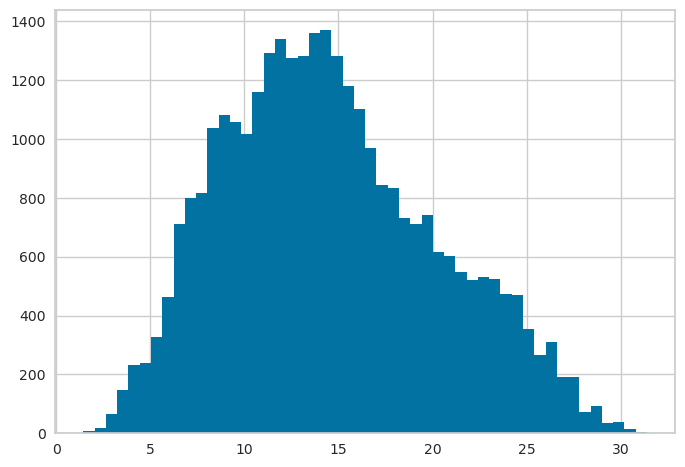

In [32]:
import matplotlib.pyplot as plt
plt.hist(unseen_predictions_gbm['prediction_label'], bins=50)
plt.show()